In [1]:
#!pip install something_missing

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import time
import copy
from sklearn.datasets import make_classification
from alipy import ToolBox

2022-03-23 16:57:16.702552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 16:57:16.702594: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Check Gpu
tf.test.gpu_device_name()

2022-03-23 16:57:19.335762: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 16:57:19.338417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-23 16:57:19.338458: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-23 16:57:19.338498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ax1): /proc/driver/nvidia/version does not exist


''

In [4]:
# Import the Dataset
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [5]:
print(df.shape)

(6920, 2)


In [6]:
# Limit dataframe to work faster
#df = df[:500]

In [7]:
# Get total number of positive and negative reviews
df[1].value_counts()

1    3610
0    3310
Name: 1, dtype: int64

In [8]:
# Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

# Create Bert tokenizer class
tokenizer_class = ppb.BertTokenizer

# Save the weights for uncased Bert 
pretrained_weights = 'bert-base-uncased'

# Create a tokenizer from tokenizer class
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

# Tokenize all of the sentences 
tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [9]:
tokenized

0       [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1       [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2       [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3       [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4       [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
                              ...                        
6915    [101, 9145, 1010, 7570, 18752, 14116, 1998, 28...
6916    [101, 2202, 2729, 2003, 19957, 2864, 2011, 103...
6917    [101, 1996, 5896, 4472, 4121, 1010, 3082, 7832...
6918    [101, 1037, 5667, 2919, 2143, 2007, 5667, 2561...
6919    [101, 1037, 12090, 2135, 2512, 5054, 19570, 23...
Name: 0, Length: 6920, dtype: object

In [10]:
tokenized.shape

(6920,)

In [11]:
# Add padding to all of the sentences so that they have the same size
# So the input can be represented as a 2d array
# Important for performance

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

padded

array([[  101,  1037, 18385, ...,     0,     0,     0],
       [  101,  4593,  2128, ...,     0,     0,     0],
       [  101,  2027,  3653, ...,     0,     0,     0],
       ...,
       [  101,  1996,  5896, ...,     0,     0,     0],
       [  101,  1037,  5667, ...,     0,     0,     0],
       [  101,  1037, 12090, ...,     0,     0,     0]])

In [12]:
np.array(padded).shape

(6920, 67)

In [13]:
# Attention mask is created to mask the padded values
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [14]:
attention_mask.shape

(6920, 67)

In [15]:
# For DistilBERT:

# Create config just in case 
config = ppb.BertConfig(output_hidden_states=True)
model_class = ppb.BertModel(config=config)

# Load pretrained model/tokenizer
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# Check model config 
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [17]:
# Transform padded to a tensor 
input_ids = torch.tensor(padded)  

# Transfer mask to a tensor 
attention_mask = torch.tensor(attention_mask)

# Run the sentences through BERT save the states of each layer to hidden_states
with torch.no_grad():    
    outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)

In [18]:
len(outputs)

3

In [19]:
#outputs[2] gets all of the 12 layers

hidden_states = outputs[2]

In [20]:
len(hidden_states)

13

In [21]:
embedding_output = hidden_states[0]

layer_1 = hidden_states[1]
layer_2 = hidden_states[2]
layer_3 = hidden_states[3]
layer_4 = hidden_states[4]
layer_5 = hidden_states[5]
layer_6 = hidden_states[6]
layer_7 = hidden_states[7]
layer_8 = hidden_states[8]
layer_9 = hidden_states[9]
layer_10 = hidden_states[10]
layer_11 = hidden_states[11]
layer_12 = hidden_states[12]

In [22]:
# Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. 
# The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. 
# The output corresponding to that token can be thought of as an embedding for the entire sentence.
# We'll save those in the features variable, as they'll serve as the features to our random forest classifier.

features_1 = layer_1[:,0,:].numpy()
features_2 = layer_2[:,0,:].numpy()
features_3 = layer_3[:,0,:].numpy()
features_4 = layer_4[:,0,:].numpy()
features_5 = layer_5[:,0,:].numpy()
features_6 = layer_6[:,0,:].numpy()
features_7 = layer_7[:,0,:].numpy()
features_8 = layer_8[:,0,:].numpy()
features_9 = layer_9[:,0,:].numpy()
features_10 = layer_10[:,0,:].numpy()
features_11 = layer_11[:,0,:].numpy()
features_12 = layer_12[:,0,:].numpy()

# Save the CLS values in a list to iterate them on the model
CLS_layers = (features_1, features_2, features_3, features_4, features_5, features_6, features_7,
                features_8, features_9, features_10, features_11, features_12)

labels = df[1]
labels_np = labels.to_numpy()

labels_np.shape

(6920,)

In [23]:
# Define active learning loop using ALiPy
# Check http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/huangsj/alipy/example.html#collapseOne

def main_loop(alibox, strategy, round):
        # Get the data split of one fold experiment
        train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)
        # Get intermediate results saver for one fold experiment
        saver = alibox.get_stateio(round, saving_path=f"./{strategy.__class__.__name__}_{round}.pkl")

        # Set initial performance point
        model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
        pred = model.predict(X[test_idx, :])
        accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                  y_pred=pred,
                                                  performance_metric='accuracy_score')
        saver.set_initial_point(accuracy)

        # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.
        while not stopping_criterion.is_stop():
            # Select a subset of Uind according to the query strategy
            # Passing model=None to use the default model for evaluating the committees' disagreement
            # Set batch size 2
            select_ind = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, batch_size=32, model=model)
            label_ind.update(select_ind)
            unlab_ind.difference_update(select_ind)

            # Update model and calc performance according to the model you are using
            model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
            pred = model.predict(X[test_idx, :])
            accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                      y_pred=pred,
                                                      performance_metric='accuracy_score')

            # Save intermediate results to file
            st = alibox.State(select_index=select_ind, performance=accuracy)
            saver.add_state(st)
            saver.save()

            # Passing the current progress to stopping criterion object
            stopping_criterion.update_information(saver)
        # Reset the progress in stopping criterion object
        stopping_criterion.reset()
        return saver

In [24]:
# Define some stuff for AL loop

# How many AL iterations
n_iterations = 500 
# How many different test/train splits
n_exp = 5

In [25]:
unc_results_1_2 = []
unc_results_2_3 = []
unc_results_3_4 = []
unc_results_4_5 = []
unc_results_5_6 = []
unc_results_6_7 = []
unc_results_7_8 = []
unc_results_8_9 = []
unc_results_9_10 = []
unc_results_10_11 = []
unc_results_11_12 = []

unc_results_2_add = (unc_results_1_2, unc_results_2_3, unc_results_3_4, unc_results_4_5, unc_results_5_6, unc_results_6_7,
               unc_results_7_8, unc_results_8_9, unc_results_9_10, unc_results_10_11, unc_results_11_12)

unc_results_2_cct = (unc_results_1_2, unc_results_2_3, unc_results_3_4, unc_results_4_5, unc_results_5_6, unc_results_6_7,
               unc_results_7_8, unc_results_8_9, unc_results_9_10, unc_results_10_11, unc_results_11_12)

In [26]:
CLS_layers[0]

array([[ 0.06552885,  0.03916041, -0.15543425, ...,  0.19716711,
        -0.07643953,  0.0253779 ],
       [ 0.14467494,  0.0573497 , -0.12528946, ...,  0.09880017,
         0.06050295,  0.14125246],
       [ 0.04235384,  0.03714702, -0.22564028, ...,  0.22175388,
        -0.0387379 , -0.01211371],
       ...,
       [ 0.01120537,  0.03956194, -0.22162904, ...,  0.22863002,
        -0.09343314, -0.00185291],
       [ 0.22546524,  0.02270092, -0.10441812, ...,  0.11391183,
        -0.00211675,  0.14312214],
       [ 0.10785748,  0.06214891, -0.09431638, ...,  0.1157391 ,
         0.03829587,  0.06013294]], dtype=float32)

In [27]:
# get layer combinations for concantenation

cct_1_2 = np.concatenate((CLS_layers[0], CLS_layers[1]), axis=1)
cct_2_3 = np.concatenate((CLS_layers[1], CLS_layers[2]), axis=1)
cct_3_4 = np.concatenate((CLS_layers[2], CLS_layers[3]), axis=1)
cct_4_5 = np.concatenate((CLS_layers[3], CLS_layers[4]), axis=1)
cct_5_6 = np.concatenate((CLS_layers[4], CLS_layers[5]), axis=1)
cct_6_7 = np.concatenate((CLS_layers[5], CLS_layers[6]), axis=1)
cct_7_8 = np.concatenate((CLS_layers[6], CLS_layers[7]), axis=1)
cct_8_9 = np.concatenate((CLS_layers[7], CLS_layers[8]), axis=1)
cct_9_10 = np.concatenate((CLS_layers[8], CLS_layers[9]), axis=1)
cct_10_11 = np.concatenate((CLS_layers[9], CLS_layers[10]), axis=1)
cct_11_12 = np.concatenate((CLS_layers[10], CLS_layers[11]), axis=1)


cct_layers = (cct_1_2, cct_2_3, cct_3_4, cct_4_5, cct_5_6, cct_6_7, cct_7_8, cct_8_9, cct_9_10 ,cct_10_11, cct_11_12)


In [28]:
# Iterate through CLS tokens of the concantaned 
for i in range(len(cct_layers)):

    X=cct_layers[i]
    y=labels_np

    alibox = ToolBox(X=X, y=y, query_type='AllLabels', saving_path='.')

    # Split data
    alibox.split_AL(test_ratio=0.3, initial_label_rate=0.1, split_count=10)

    # Use the default Logistic Regression classifier
    model = alibox.get_default_model()

    # The cost budget is 50 times querying
    stopping_criterion = alibox.get_stopping_criterion('num_of_queries', n_iterations)
    

    for round in range(n_exp):
        train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

        # Use pre-defined strategy
        unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")

        unc_results_2_cct[i].append(copy.deepcopy(main_loop(alibox, unc, round)))
        


| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   484 (9.99% of all)   |        137        |  0   | 0.767 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: |
|   1   |   484 (9.99% of all)   |        137        |  0   | 0.746 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: |
|   2   |   484 (9.99% of all)   |        137        |  0   | 0.765 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: |
|   3   |   484 (9.99% of all)   |        137        |  0   | 0.743 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: |
|   4   |   484 (9.99% of all)   |        137        |  0   | 0.755 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   484 (9.99% of all)   |        137        |  0   | 0.768 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: 


+--------------+-------------------+---------------------------+--------------+------------+
|   Methods    | number_of_queries | number_of_different_split | performance  | batch_size |
+--------------+-------------------+---------------------------+--------------+------------+
| Unc_Layer_11 |        137        |             5             | 0.832 ± 0.01 |     32     |
| Unc_Layer_10 |        137        |             5             | 0.830 ± 0.00 |     32     |
| Unc_Layer_9  |        137        |             5             | 0.824 ± 0.00 |     32     |
| Unc_Layer_8  |        137        |             5             | 0.808 ± 0.00 |     32     |
| Unc_Layer_7  |        137        |             5             | 0.781 ± 0.01 |     32     |
| Unc_Layer_6  |        137        |             5             | 0.777 ± 0.01 |     32     |
| Unc_Layer_5  |        137        |             5             | 0.779 ± 0.01 |     32     |
| Unc_Layer_4  |        137        |             5             | 0.76

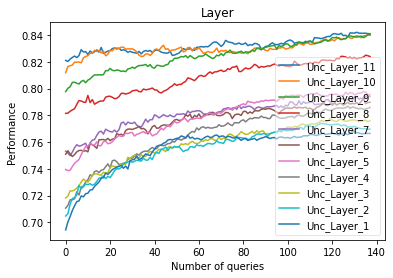

In [29]:
analyser = alibox.get_experiment_analyser(x_axis='num_of_queries')

for i in range(len(unc_results_2_cct)):
    
    # Iterationg results in reverse beacues 12th layer has the best performance and will stay at top
    # On the plot we want to somehow corralete the layer and the plot
    analyser.add_method(method_name='Unc_Layer_' + str(11-i), method_results=unc_results_2_cct[10-i])        
    

    
print(analyser)
analyser.plot_learning_curves(title='Layer', std_area=False)